Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [105]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [98]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    X['gps_height'] = X['gps_height'].replace([-90], X['gps_height'].mean())
    X['gps_height'] = X['gps_height'].replace([X['gps_height']<0], np.nan)
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# # Merge train_features.csv & train_labels.csv
# train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
#                  pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# # Read test_features.csv & sample_submission.csv
# test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
# sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# # Split train into train & val. Make val the same size as test.
# target = 'status_group'
# train, val = train_test_split(train, test_size=len(test),  
#                               stratify=train[target], random_state=42)

# # Wrangle train, validate, and test sets in the same way
# train = wrangle(train)
# val = wrangle(val)
# test = wrangle(test)

# # Arrange data into X features matrix and y target vector
# X_train = train.drop(columns=target)
# y_train = train[target]
# X_val = val.drop(columns=target)
# y_val = val[target]
# X_test = test

# # Make pipeline!
# pipeline = make_pipeline(
#     ce.OrdinalEncoder(), 
#     SimpleImputer(strategy='mean'), 
#     RandomForestClassifier(n_estimators=100, random_state=7, n_jobs=-1)
# )

# # Fit on train, score on val
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_val)
# print('Validation Accuracy', accuracy_score(y_val, y_pred))

In [12]:
# This is hard to read
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[6987,  178,  633],
       [ 547,  331,  165],
       [1103,   75, 4339]], dtype=int64)

In [13]:
# We need to get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [14]:

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,6987,178,633
Actual functional needs repair,547,331,165
Actual non functional,1103,75,4339


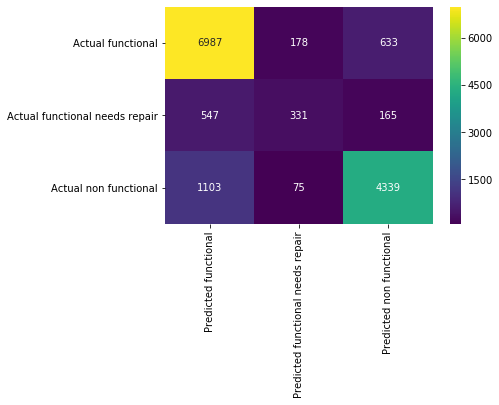

In [16]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [17]:
baseline = accuracy_score(y_val, y_pred)
baseline

0.8118818776988439

In [19]:
from sklearn.metrics import classification_report
baseline_classification = classification_report(y_val, y_pred)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.57      0.32      0.41      1043
         non functional       0.84      0.79      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.67      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



In [20]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [21]:
trips = 3000
print(f'Baseline: {trips * 0.46} waterpumps repairs in {trips} trips')

Baseline: 1380.0 waterpumps repairs in 3000 trips


In [22]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [23]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

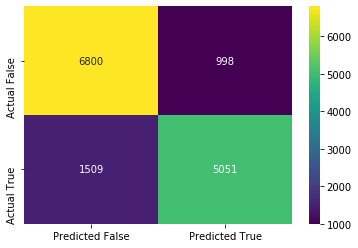

In [24]:
plot_confusion_matrix(y_val, y_pred);

False    12131
True      2227
dtype: int64

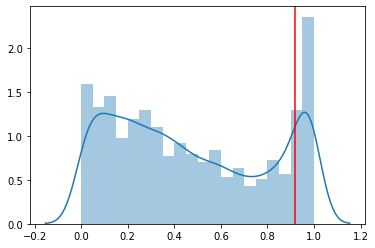

In [26]:
threshold = 0.92

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')
pd.Series(y_pred).value_counts()

In [27]:
from ipywidgets import interact, fixed

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)
    
interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [29]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:3000]

In [35]:
trips = 3000
print(f'Baseline: {trips * 0.46} waterpumps repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict that {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 1380.0 waterpumps repairs in 3000 trips
With model: Predict that 2936 waterpump repairs in 3000 trips


In [37]:
precision_at_k2000 = relevant_recommendations / trips
print('Precision @ k=3000', precision_at_k2000)

Precision @ k=3000 0.9786666666666667


# I will continue my quest for a higher score on the kaggle.

In [116]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    X['gps_height'] = X['gps_height'].replace([-90], X['gps_height'].mean())
    X['gps_height'] = X['gps_height'].replace([X['gps_height']<0], np.nan)
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X


# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
final = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
# train, val = train_test_split(train, test_size=len(test),  
#                               stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)
final = wrangle(final)
# Arrange data into X features matrix and y target vector
# X_train = train.drop(columns=target)
# y_train = train[target]
# X_val = val.drop(columns=target)
# y_val = val[target]
# X_test = test

# Make pipeline!
# pipeline = make_pipeline(
#     ce.OrdinalEncoder(), 
#     SimpleImputer(strategy='mean'), 
#     RandomForestClassifier(n_estimators=100, random_state=7, n_jobs=-1)
# )

# # Fit on train, score on val
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_val)
# print('Validation Accuracy', accuracy_score(y_val, y_pred))

KeyError: 'date_recorded'

In [ ]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target])

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())])

# Get a list of all categorical features with cardinality <= 50

categorical_features = cardinality[cardinality <= 130].index.tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ce.OneHotEncoder(use_cat_names=True)),
    ('kbest', SelectKBest(k = 100))])

ordinal_features = cardinality[cardinality >= 130].index.tolist()
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', ce.OrdinalEncoder()),
    ('kbest', SelectKBest(k = 'all'))])

target_features = target
target_transformer = Pipeline(steps=[('label', LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features)])

# ('tar', target_transformer, target_features)

features = numeric_features + categorical_features + ordinal_features

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_final = final[features]
y_final = final[target]


#X_final = X_final[(X_final[numeric_features] >= np.percentile(X_final[numeric_features], 0.5))]
# X_train = train.drop(columns=target)
# y_train = train.drop(columns=features)
# X_val = val.drop(columns=target)
# y_val = val[target]
# X_test = test
# X_final = final.drop(columns=target)
# y_final = final[target]

# Combine the lists 
# features = numeric_features + categorical_features + ordinal_features
print(features)

In [ ]:
# pipeline = make_pipeline(
#     ce.TargetEncoder(), 
#     SimpleImputer(), 
#     RandomForestRegressor(random_state=42)
# )
from scipy.stats import randint, uniform
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          # ('targetencoder',ce.TargetEncoder()),
                      ('classifier', RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1))])
param_distributions = {
#    'targetencoder__min_samples_leaf': randint(1, 1000), 
#    'targetencoder__smoothing': uniform(1, 1000), 
#    'simpleimputer__strategy': ['mean', 'median'], 
    #'preprocessor__num__imputer__strategy': ['mean', 'most_frequent'],
    'preprocessor__cat__kbest__k': range(0, len(X_train.columns)+1),
    'preprocessor__ord__kbest__k': range(5,7),
    'classifier__n_estimators': randint(200, 300), 
    'classifier__max_depth': [60, 65, 70], 
    'classifier__max_features': uniform(0, .5), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    #scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_final, y_final);

print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

In [ ]:
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_test)
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('your-submission-filename.csv', index=False)
!kaggle competitions submit -c ds8-predictive-modeling-challenge -f your-submission-filename.csv -m "Using randomized searchCV got a .79 MAE"

In [39]:
print(baseline)
print(baseline_classification)

0.8118818776988439
                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.57      0.32      0.41      1043
         non functional       0.84      0.79      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.67      0.69     14358
           weighted avg       0.81      0.81      0.80     14358



In [84]:
correlation_matrix = train.corr()
correlation_matrix = abs(correlation_matrix)
correlation_matrix = correlation_matrix[correlation_matrix <= .05]

In [93]:
corr = final.corr()

In [85]:
correlation_matrix

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,year_recorded,month_recorded,day_recorded,years
amount_tsh,NaN,0.033246,0.011247,0.046551,0.002690,0.024596,0.021450,0.001575,0.006162,0.004573,0.034783,0.001862,NaN
gps_height,0.033246,NaN,NaN,NaN,0.013852,NaN,NaN,0.040641,0.016684,NaN,NaN,0.032078,0.030140
longitude,0.011247,NaN,NaN,NaN,0.040814,NaN,NaN,NaN,0.029511,NaN,NaN,0.014781,NaN
latitude,0.046551,NaN,NaN,NaN,0.010720,NaN,NaN,0.049009,0.039237,NaN,NaN,0.007022,NaN
num_private,0.002690,0.013852,0.040814,0.010720,NaN,0.018061,0.002792,0.002552,0.000379,0.008664,0.020585,0.004916,0.023226
region_code,0.024596,NaN,NaN,NaN,0.018061,NaN,NaN,NaN,0.009014,NaN,NaN,NaN,0.031355
district_code,0.021450,NaN,NaN,NaN,0.002792,NaN,NaN,0.041839,0.010174,0.018960,NaN,0.046315,NaN
population,0.001575,0.040641,NaN,0.049009,0.002552,NaN,0.041839,NaN,0.034325,0.035540,0.006817,0.040927,0.019731
construction_year,0.006162,0.016684,0.029511,0.039237,0.000379,0.009014,0.010174,0.034325,NaN,0.014257,0.006990,NaN,NaN
year_recorded,0.004573,NaN,NaN,NaN,0.008664,NaN,0.018960,0.035540,0.014257,NaN,NaN,0.021376,NaN


I want to make a note of the things that have high correlations, might make me overfit.

construction_year with years .99
district code with region code .68
region code with 

In [95]:
# columns = np.full((corr.shape[0],), True, dtype=bool)
# for i in range(corr.shape[0]):
#     for j in range(i+1, corr.shape[0]):
#         if corr.iloc[i,j] >= 0.9:
#             if columns[j]:
#                 columns[j] = False
# selected_columns = final.columns[columns]
# data = final[selected_columns]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 41 but corresponding boolean dimension is 10

In [86]:
# selected_columns = selected_columns[1:].values
# import statsmodels.formula.api as sm
# def backwardElimination(x, Y, sl, columns):
#     numVars = len(x[0])
#     for i in range(0, numVars):
#         regressor_OLS = sm.OLS(Y, x).fit()
#         maxVar = max(regressor_OLS.pvalues).astype(float)
#         if maxVar > sl:
#             for j in range(0, numVars - i):
#                 if (regressor_OLS.pvalues[j].astype(float) == maxVar):
#                     x = np.delete(x, j, 1)
#                     columns = np.delete(columns, j)
                    
#     regressor_OLS.summary()
#     return x, columns
# SL = 0.05
# data_modeled, selected_columns = backwardElimination(data.iloc[:,1:].values, data.iloc[:,0].values, SL, selected_columns)

NameError: name 'selected_columns' is not defined